In [137]:
import os
import json
import pandas as pd
from datetime import datetime
from datetime import timedelta
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from time import time

In [ ]:

base_path = "C:/tzuen/ML/final project/data"
date_folders = os.listdir(base_path)
# print(date_folders)


In [12]:
def date_trans(ymd, hm):
    return f"{ymd[:4]}-{ymd[4:6]}-{ymd[6:]} {hm}"


In [14]:

csv_file = "transformed.csv"
# Create a list to store data
location_columns = [s[:-5] for s in os.listdir(f"{base_path}/{date_folders[0]}")]
print(location_columns)



['500101001', '500101002', '500101003', '500101004', '500101005', '500101006', '500101007', '500101008', '500101009', '500101010', '500101013', '500101014', '500101015', '500101018', '500101019', '500101020', '500101021', '500101022', '500101023', '500101024', '500101025', '500101026', '500101027', '500101028', '500101029', '500101030', '500101031', '500101032', '500101033', '500101034', '500101035', '500101036', '500101037', '500101038', '500101039', '500101040', '500101041', '500101042', '500101091', '500101092', '500101093', '500101094', '500101114', '500101115', '500101123', '500101166', '500101175', '500101176', '500101181', '500101184', '500101185', '500101188', '500101189', '500101190', '500101191', '500101193', '500101199', '500101209', '500101216', '500101219', '500105066', '500106002', '500106003', '500106004', '500119043', '500119044', '500119045', '500119046', '500119047', '500119048', '500119049', '500119050', '500119051', '500119052', '500119053', '500119054', '500119055'

In [15]:

df = pd.DataFrame()
# Iterate over dates
for date_folder in date_folders:
    date_df = pd.DataFrame()
    # Iterate over location files
    for location_file in os.listdir(f"{base_path}/{date_folder}"):
        location_path = os.path.join(base_path, date_folder, location_file)
        flag = True
        with open(location_path, "r") as json_file:
            json_data = json.load(json_file)
            if flag:
                date_df["Time"] = [date_trans(date_folder, hm) for hm in json_data.keys()]
                flag = False
            sbi_list = []
            for min_time in json_data.keys():
                if json_data[min_time]["act"] == "1":
                    sbi_list.append(json_data[min_time]["sbi"])
                else:
                    sbi_list.append(-1)
            date_df[location_file[:-5]] = sbi_list

    df = pd.concat([df, date_df])
df.to_csv("transformed_sbi.csv", index = False)


C:\Users\Ding\AppData\Local\Temp/ipykernel_19820/3611854209.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  date_df[location_file[:-5]] = sbi_list
C:\Users\Ding\AppData\Local\Temp/ipykernel_19820/3611854209.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  date_df[location_file[:-5]] = sbi_list
C:\Users\Ding\AppData\Local\Temp/ipykernel_19820/3611854209.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

In [16]:
sbi_df = df

In [49]:

def parser(s):
    return datetime.strptime(s, "%Y-%m-%d %H:%M")

In [18]:
def perform_adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')

In [50]:

sbi_df = pd.read_csv("transformed_sbi.csv", parse_dates=[0], index_col=0, date_parser = parser)


C:\Users\Ding\AppData\Local\Temp/ipykernel_19820/1841227146.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  sbi_df = pd.read_csv("transformed_sbi.csv", parse_dates=[0], index_col=0, date_parser = parser)


In [20]:
print(sbi_df[location_columns[0]])

Time
2023-10-02 00:00:00    12
2023-10-02 00:01:00    12
2023-10-02 00:02:00    13
2023-10-02 00:03:00    13
2023-10-02 00:04:00    13
                       ..
2023-11-06 23:55:00    21
2023-11-06 23:56:00    21
2023-11-06 23:57:00    21
2023-11-06 23:58:00    23
2023-11-06 23:59:00    23
Name: 500101001, Length: 40320, dtype: int64


In [148]:
def plot_series(series):
    plt.figure(figsize=(12,6))
    plt.plot(series, color='red')
    plt.show()


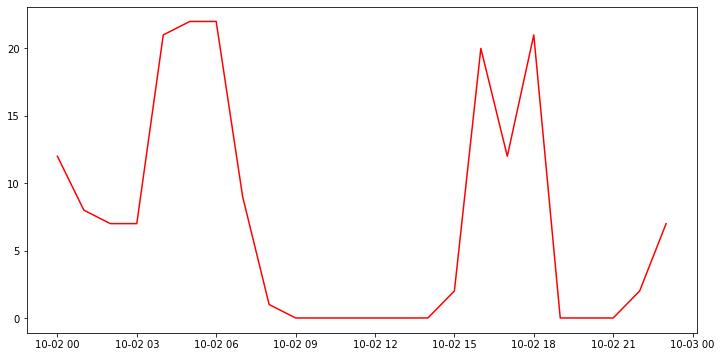

In [150]:
plot_series(test_loc[:24])

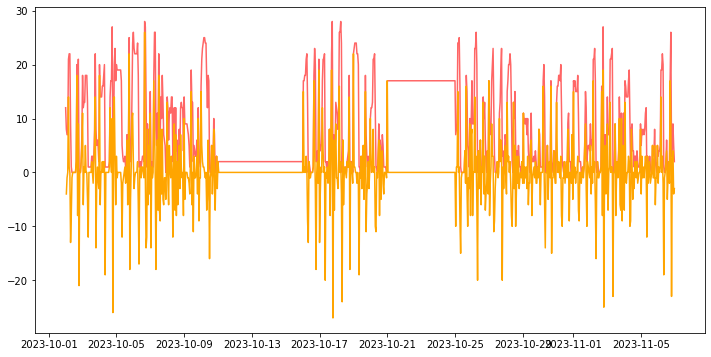

In [125]:
test_loc = sbi_df[location_columns[0]].asfreq("H", method='bfill')
test_loc_diff = test_loc.diff()[1:]
plt.figure(figsize=(12,6))
plt.plot(test_loc, alpha=0.6, color='red')
plt.plot(test_loc_diff, color='orange')
# perform_adf_test(sbi_df[location_columns[1]])

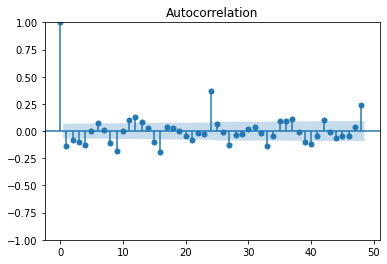

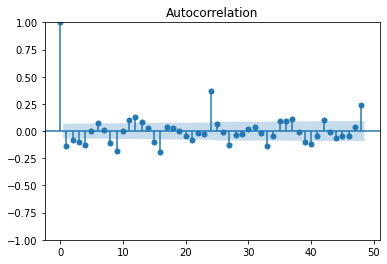

In [126]:
plot_acf(test_loc_diff, lags=48)

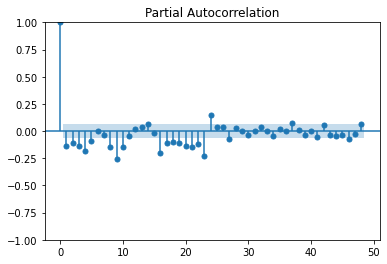

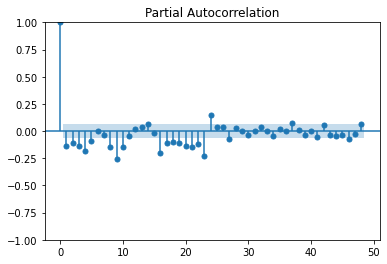

In [117]:
plot_pacf(test_loc_diff, lags=48)

In [163]:
train_end = datetime(2023,10,31,23,59)

train_set = test_loc[:train_end]
val_set = test_loc[train_end+timedelta(hours=1):]

In [164]:
order1 = (0, 1, 0)
season_order1 = (1, 0, 1, 24)
model = SARIMAX(train_set, order=order1, seasonal_order=season_order1)


In [165]:
Hour_model_fit = model.fit()

In [166]:
print(Hour_model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                            500101001   No. Observations:                  720
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 24)   Log Likelihood               -2227.484
Date:                              Tue, 28 Nov 2023   AIC                           4460.967
Time:                                      21:00:29   BIC                           4474.701
Sample:                                  10-02-2023   HQIC                          4466.269
                                       - 10-31-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       0.7224      0.050     14.320      0.000       0.624       0.821
ma.S.L24      -0.39

In [167]:
prediction1 = Hour_model_fit.forecast(len(val_set))
prediction1 = pd.Series(prediction1, index=val_set.index)
residuals1 = val_set - prediction1

In [177]:
print(np.mean(residuals1), np.mean(residuals1**2))

4.195953711402167 52.73908759910895


Text(0, 0.5, 'Error')

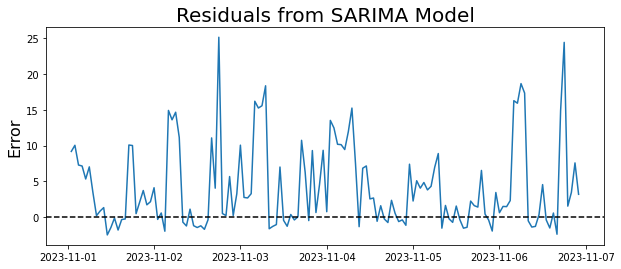

In [168]:
plt.figure(figsize=(10,4))
plt.plot(residuals1)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

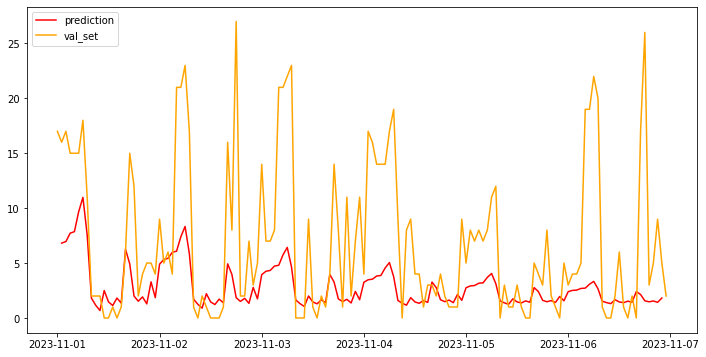

In [169]:
plt.figure(figsize=(12,6))
plt.plot(prediction1, color='red', label = 'prediction')
plt.plot(test_loc[-144:], color='orange', label = 'val_set')
plt.legend()

In [170]:
rolling_predictions1 = val_set.copy()
for train_end in val_set.index:
    train_data = test_loc[:train_end-timedelta(hours=1)]
    model = SARIMAX(train_data, order=order1, seasonal_order=season_order1)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions1[train_end] = pred

C:\Users\Ding\AppData\Local\Temp/ipykernel_19820/2754655181.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions1[train_end] = pred
C:\Users\Ding\AppData\Local\Temp/ipykernel_19820/2754655181.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions1[train_end] = pred
C:\Users\Ding\AppData\Local\Temp/ipykernel_19820/2754655181.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions1[train_end] = pred
C:\Users\Ding\AppData\Local\Temp/ipykernel_19820/2754655181.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions1[train_end] = pred


Text(0, 0.5, 'Error')

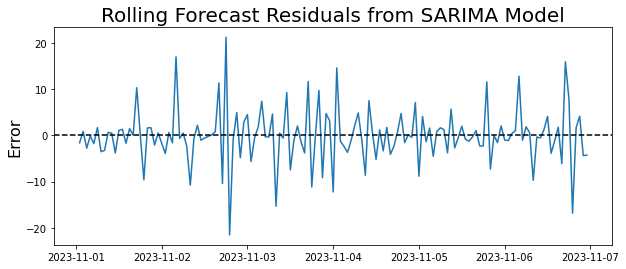

In [171]:
rolling_residuals1 = val_set - rolling_predictions1
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals1)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

In [178]:
print(np.mean(rolling_predictions1), np.mean(rolling_predictions1**2))

7.052183125875263 94.14906593488794


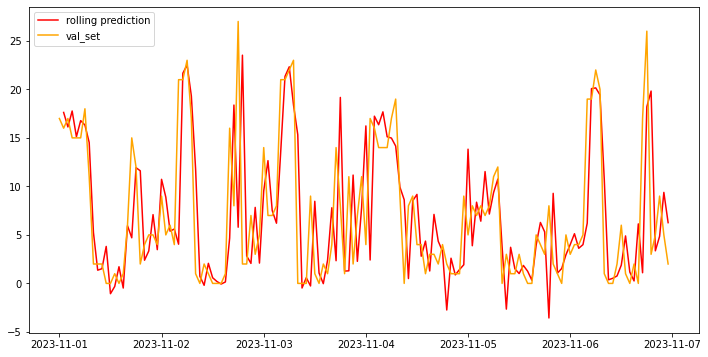

In [172]:
plt.figure(figsize=(12,6))
plt.plot(rolling_predictions1, color='red', label = 'rolling prediction')
plt.plot(test_loc[-144:], color='orange', label = 'val_set')
plt.legend()

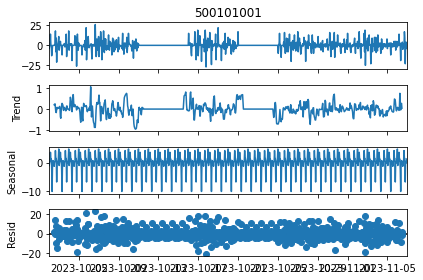

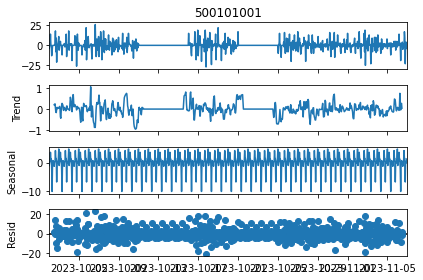

In [128]:
decompose_result = seasonal_decompose(test_loc_diff, period=24, model='add')
decompose_result.plot()

In [130]:
perform_adf_test(test_loc_diff.dropna())

ADF Statistic: -14.321689371570375
p-value: 1.1384242832865013e-26


In [136]:
perform_adf_test(decompose_result.trend.dropna())

ADF Statistic: -6.957645181385809
p-value: 9.339264993405245e-10


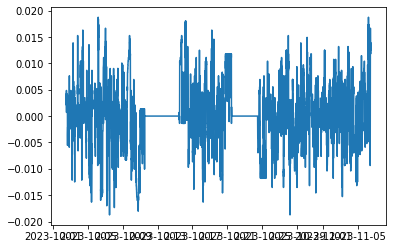

In [92]:
plt.plot(decompose_result.trend.diff()[1:])

In [108]:
perform_adf_test(decompose_result.trend.diff().dropna())

ADF Statistic: -12.30991080397427
p-value: 7.130518074082618e-23


In [87]:
perform_adf_test(decompose_result.resid.dropna())

ADF Statistic: -14.479180707199765
p-value: 6.414577054541819e-27


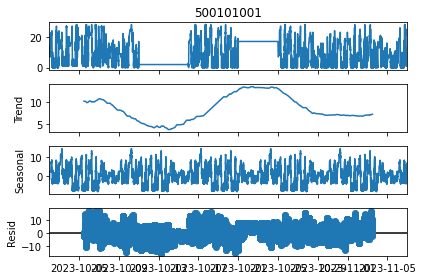

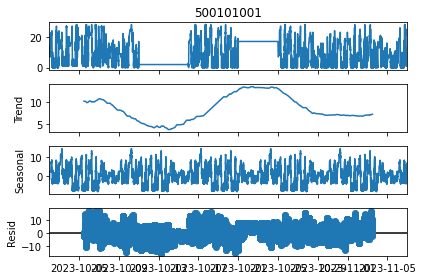

In [81]:
result = seasonal_decompose(test_loc, period=1440*7, model='add')
result.plot()